<a href="https://colab.research.google.com/github/TonQiaN/colab/blob/main/9444project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!python -m pip install --upgrade pip -q
!pip install matplotlib -q -U
!pip install -q datasets
!pip install transformers -q -U
!pip install -q bitsandbytes sentencepiece accelerate loralib
!pip install -q git+https://github.com/huggingface/peft.git
!pip install hf_transfer -q
!pip install pickleshare -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 46.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.9 MB/s eta 0:00:00


In [ ]:
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset

In [ ]:
# 下载数据库
# # Make sure you have git-lfs installed (https://git-lfs.com)
# git lfs install

# git clone https://huggingface.co/datasets/Trelis/chess_pieces

In [ ]:
# 读取训练和测试数据集
train_df = pd.read_parquet("./chess_pieces/data/train-00000-of-00001.parquet")
test_df = pd.read_parquet("./chess_pieces/data/test-00000-of-00001.parquet")

# 展示数据集原生样貌
train_df.head()

,image,caption
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A single white rook.
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A white rook.
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"One white chess piece, namely - a rook."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,A white pawn.
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,One white pawn.


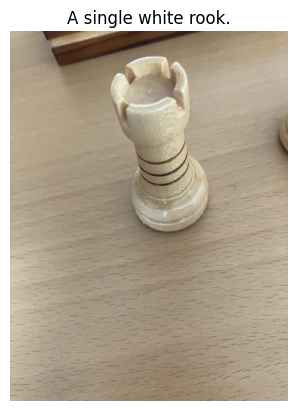

In [ ]:
# 获取第一个图像字节流
image_bytes = train_df.loc[0, 'image']['bytes']
caption = train_df.loc[0, 'caption']

# 将字节流转换为图像
image = Image.open(io.BytesIO(image_bytes))

# 显示第一个数据集例子
plt.imshow(image)
plt.axis('off')
plt.title(caption)
plt.show()

In [ ]:
# 检查当前路径下是否有名为 "LLaVA" 的目录
if not os.path.isdir("LLaVA"):
    # 如果没有，则使用 git clone 命令从 GitHub 仓库克隆项目
    !git clone https://github.com/haotian-liu/LLaVA.git
else:
    # 如果目录已经存在，打印提示信息
    print("LLaVA directory already exists. Skipping clone.")

Cloning into 'LLaVA'...


In [2]:
# 查看分配的 GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# 查看可用内存
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Fine-tune and deploy the multimodal LLaVA model with DeepSpeed
https://console.brev.dev/launchable/deploy/now?userID=p2mzt91a8&orgID=jnj0c501d&launchableID=env-2hpxJ6HArVk5jzOYgJmFDJfvNmH&instance=A10G%40g5.12xlarge&diskStorage=300&cloudID=devplane-brev-1&python=3.10&cuda=12.2.2&file=https%3A%2F%2Fgithub.com%2Fbrevdev%2Fnotebooks%2Fblob%2Fmain%2Fllava-finetune.ipynb&name=Fine-tune+and+deploy+multimodal+LLaVA-1.5

https://www.youtube.com/watch?v=XICHJx2_Rm8&t=774s



In [ ]:
# # Install preprocessing libraries
# !pip install --upgrade --force-reinstall Pillow

这段代码的主要功能是将从 Hugging Face 加载的图像数据集（包括图像和对应问题回答的文本内容）处理为特定的 JSON 格式，并保存到指定文件夹。每个图像保存为唯一的 .jpg 文件，JSON 文件中记录了图像的文件名、ID 以及与该图像对应的对话内容（问题和回答），可以用于下游任务（如 LLaVA）的模型训练和微调。

In [1]:
# Imports
from datasets import load_dataset
from PIL import Image
from io import BytesIO
import requests
import os
import json
import uuid

# Check PIL import
import PIL.Image

# Define preprocessing functions
def process_and_save(dataset, output_folder, subset_name):
    # Define image subfolder within output folder
    subset_folder = os.path.join(output_folder, subset_name)
    image_subfolder = os.path.join(output_folder, 'images')

    if not os.path.exists(image_subfolder):
        os.makedirs(image_subfolder)

    if not os.path.exists(subset_folder):
        os.makedirs(subset_folder)

    # Initialize list to hold all JSON data
    json_data_list = []

    # Process and save images and labels
    for item in dataset:
        # Load image if it's a URL or a file path
        if isinstance(item['image'], str):
            response = requests.get(item['image'])
            image = Image.open(BytesIO(response.content))
        else:
            image = item['image']  # Assuming it's a PIL.Image object

        # Create a unique ID for each image
        unique_id = str(uuid.uuid4())

        # Define image path
        image_path = os.path.join(image_subfolder, f"{unique_id}.jpg")

        # Save image
        image.save(image_path)

        # Remove duplicates and format answers
        answers = item['answers']
        unique_answers = list(set(answers))
        formatted_answers = ", ".join(unique_answers)

        # Structure for LLaVA JSON
        json_data = {
            "id": unique_id,
            "image": f"{unique_id}.jpg",
            "conversations": [
                {
                    "from": "human",
                    "value": item['question']
                },
                {
                    "from": "gpt",
                    "value": formatted_answers
                }
            ]
        }

        # Append to list
        json_data_list.append(json_data)

    # Save the JSON data list to a file
    json_output_path = os.path.join(output_folder, subset_name, 'dataset.json')
    with open(json_output_path, 'w') as json_file:
        json.dump(json_data_list, json_file, indent=4)

def save_dataset(dataset_name, output_folder, class_name, subset_name, val_samples=None):
    # Load the dataset from Hugging Face
    dataset = load_dataset(dataset_name, split=subset_name)

    # Filter for images with the specified class in 'question_type'
    filtered_dataset = [item for item in dataset if item['question_type'] == class_name]

    # Determine the split for training and validation
    if val_samples is not None and subset_name == 'train':
        train_dataset = filtered_dataset[val_samples:]
        val_dataset = filtered_dataset[:val_samples]
    else:
        train_dataset = filtered_dataset
        val_dataset = []

    # Process and save the datasets
    for subset, data in [('train', train_dataset), ('validation', val_dataset)]:
        if data:
            process_and_save(data, output_folder, subset)

该代码主要用于将 Hugging Face 上的 OK-VQA 数据集（一个多模态视觉问答数据集）按照特定的格式保存到本地文件夹中。OK-VQA 数据集主要用于训练视觉问答（Visual Question Answering）模型，即给定一张图片和一个问题，模型需要根据图像内容回答问题。

In [4]:
# Create dataset
output_folder = 'dataset'
class_name = 'other'
val_samples = 300

save_dataset('Multimodal-Fatima/OK-VQA_train', output_folder, class_name, 'train', val_samples)
save_dataset('Multimodal-Fatima/OK-VQA_test', output_folder, class_name, 'test')
# save_dataset('Trelis/chess_pieces', output_folder, class_name, 'train', val_samples)
# save_dataset('Trelis/chess_pieces', output_folder, class_name, 'test')

README.md:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

(…)-00000-of-00004-2eec69cac51b3951.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

(…)-00001-of-00004-a948ec7cb1872c0e.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

(…)-00002-of-00004-a7c653fa98b84b8e.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

(…)-00003-of-00004-bba9bf755f1aa159.parquet:   0%|          | 0.00/399M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9009 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/3.06k [00:00<?, ?B/s]

(…)-00000-of-00003-97adf921f108134e.parquet:   0%|          | 0.00/318M [00:00<?, ?B/s]

(…)-00001-of-00003-6f0954f45bdd8fb4.parquet:   0%|          | 0.00/320M [00:00<?, ?B/s]

(…)-00002-of-00003-16f57181121839f8.parquet:   0%|          | 0.00/321M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/5046 [00:00<?, ? examples/s]